In [75]:
#Telco Customer Churn Azure ML
#https://bugra.github.io/work/notes/2014-11-22/an-introduction-to-supervised-learning-scikit-learn/
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pandas as pd
import logging
import os


In [76]:
#Azure ML libraries
import azureml.core
from azureml.core import Workspace

#%% [markdown]
#Register your AML workspace
ws = Workspace.get(name='aml', subscription_id='2974583e-8d03-498f-b505-ccd068956560',resource_group='databricks-au')


In [77]:
#Setup experiemnt in AML service
from azureml.core.experiment import Experiment
experiment = Experiment(workspace=ws, name='telco-customer-churn-az-notebooks')


In [78]:
# Setup context 
from azureml.core import Run
from azureml.core import ScriptRunConfig

run = Run.get_context()
# Start a run and start the logging service.
run = experiment.start_logging()

run.log(name="message", value="Experiment started")

In [79]:
from IPython.display import Image
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import seaborn as sns


In [80]:
#Read dataset from current directory
df = pd.read_csv('telco-data.csv')

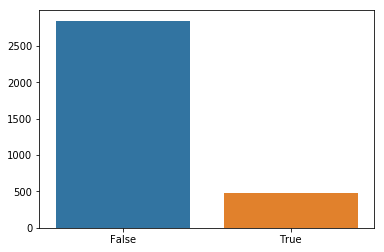

In [81]:
# Now we will import pandas to read our data from a CSV file and manipulate it for further use. We will also use numpy to convert out data into a format suitable to feed our classification model. We'll use seaborn and matplotlib for visualizations. We will then import Logistic Regression algorithm from sklearn. This algorithm will help us build our classification model. Lastly, we will use joblib available in sklearn to save our model for future use.

df.head(3)
yc = df["churn"].value_counts()
sns.barplot(yc.index, yc.values)

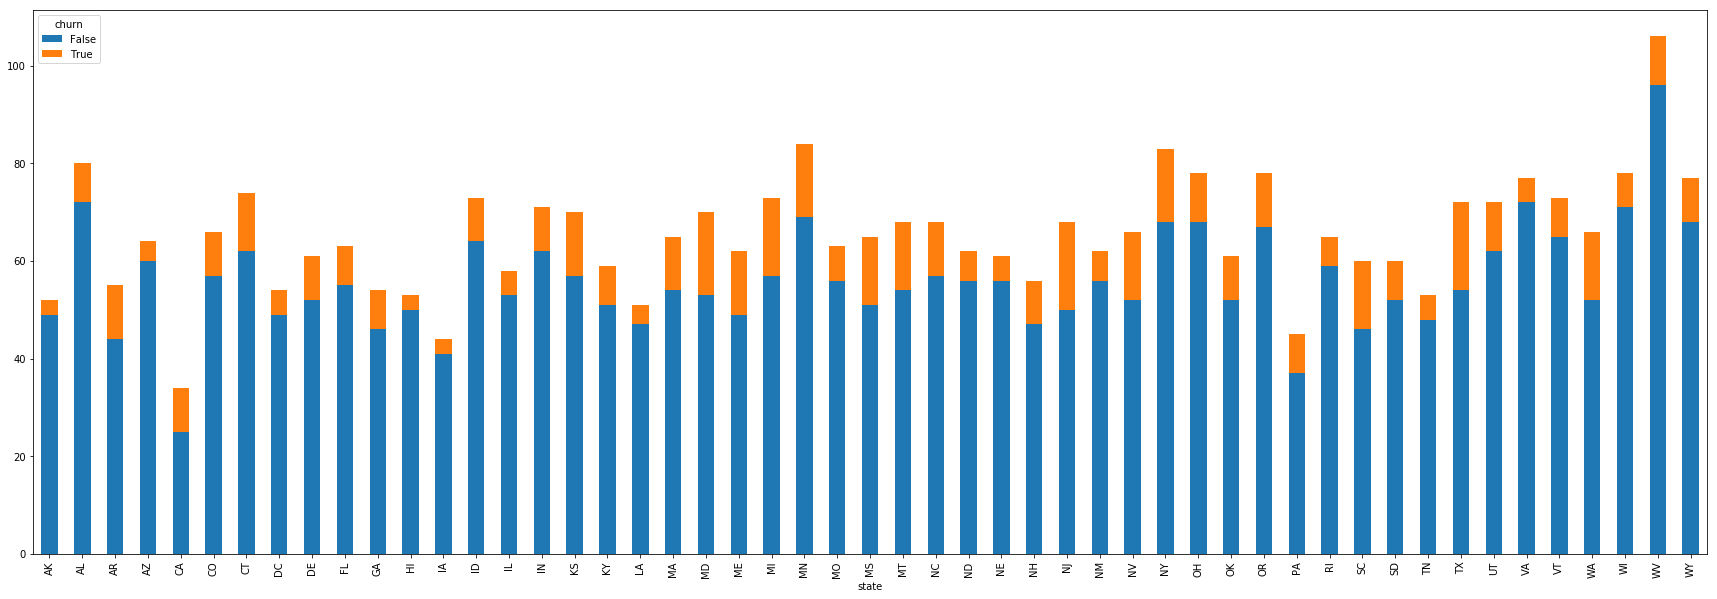

In [82]:
#Churn By State
df.groupby(["state", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(30,10)) 

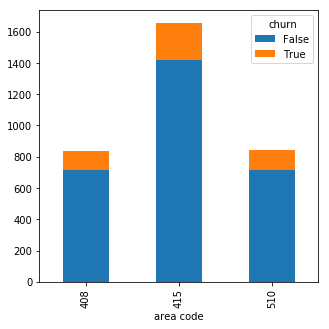

In [83]:
#Churn By Area Code
df.groupby(["area code", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5)) 


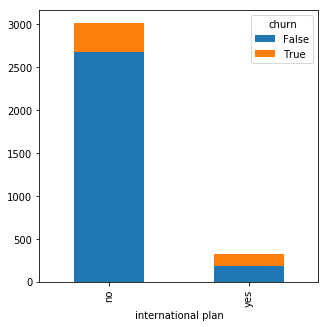

In [84]:
#Churn By Customers with International plan
df.groupby(["international plan", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5)) 


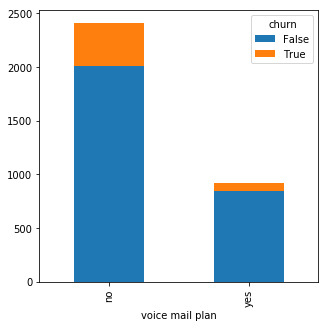

In [85]:
#Churn By Customers with Voice mail plan¶
df.groupby(["voice mail plan", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5)) 


In [86]:
# Discreet value integer encoder
label_encoder = preprocessing.LabelEncoder()


In [87]:
# State is string and we want discreet integer values
df['state'] = label_encoder.fit_transform(df['state'])
df['international plan'] = label_encoder.fit_transform(df['international plan'])
df['voice mail plan'] = label_encoder.fit_transform(df['voice mail plan'])

y = df["churn"].replace({True:1, False:0})
print (df.dtypes)

df.shape
df.head()

state                       int64
account length              int64
area code                   int64
phone number               object
international plan          int64
voice mail plan             int64
number vmail messages       int64
total day minutes         float64
total day calls             int64
total day charge          float64
total eve minutes         float64
total eve calls             int64
total eve charge          float64
total night minutes       float64
total night calls           int64
total night charge        float64
total intl minutes        float64
total intl calls            int64
total intl charge         float64
customer service calls      int64
churn                        bool
dtype: object


,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,16,128,415,382-4657,0,1,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,35,107,415,371-7191,0,1,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,31,137,415,358-1921,0,0,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,35,84,408,375-9999,1,0,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,36,75,415,330-6626,1,0,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [88]:
#Strip off Redundant cols
df.drop(["phone number","churn"], axis = 1, inplace=True)

In [89]:
#Build Feature Matrix
X = df.as_matrix().astype(np.float)
X.shape

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


(3333, 19)

In [90]:
#Standardize Feature Matrix values¶
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)


In [91]:
#Stratified Cross Validation - Since the Response values are not balanced
from sklearn.model_selection import StratifiedKFold
def stratified_cv(X, y, clf_class, shuffle=True, n_folds=10, **params):
    stratified_k_fold = StratifiedKFold(n_splits=n_folds, shuffle=shuffle)
    y_pred = y.copy()
    for train, test in stratified_k_fold.split(X, y):
        # Fit
        clf = clf_class(**params)
        clf.fit(X[train], y[train])
        # Probabilistic prediction 
        y_pred[test] = clf.predict(X[test])
    return y_pred

In [92]:
#Build Models and Train
print('Gradient Boosting Classifier:  {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, ensemble.GradientBoostingClassifier))))
print('Support vector machine(SVM):   {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, svm.SVC))))
print('Random Forest Classifier:      {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, ensemble.RandomForestClassifier))))
print('K Nearest Neighbor Classifier: {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, neighbors.KNeighborsClassifier))))
print('Logistic Regression:           {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, linear_model.LogisticRegression))))


Gradient Boosting Classifier:  0.95


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/si

Support vector machine(SVM):   0.92


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/nbuser/anaconda3_501/l

Random Forest Classifier:      0.94
K Nearest Neighbor Classifier: 0.89


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

Logistic Regression:           0.86


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


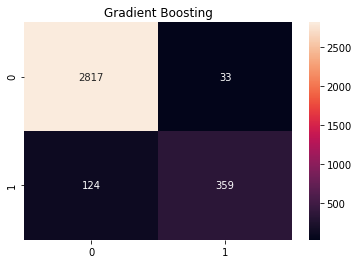

In [93]:
#Confusion Matrices for various models

grad_ens_conf_matrix      = metrics.confusion_matrix(y, stratified_cv(X, y, ensemble.GradientBoostingClassifier))
sns.heatmap(grad_ens_conf_matrix, annot=True,  fmt='');
title = 'Gradient Boosting'
plt.title(title);



/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/si

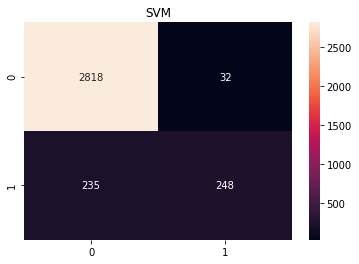

In [94]:
#%% [markdown]
svm_svc_conf_matrix       = metrics.confusion_matrix(y, stratified_cv(X, y, svm.SVC))
sns.heatmap(svm_svc_conf_matrix, annot=True,  fmt='');
title = 'SVM'
plt.title(title);

plt.savefig('plt.png')
run.log_image("Heatmap", path ="plt.png")


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/nbuser/anaconda3_501/l

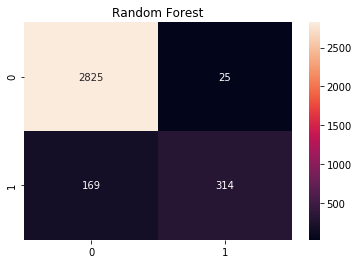

In [95]:
#%% [markdown]

random_forest_conf_matrix = metrics.confusion_matrix(y, stratified_cv(X, y, ensemble.RandomForestClassifier))
sns.heatmap(random_forest_conf_matrix, annot=True,  fmt='');
title = 'Random Forest'
plt.title(title);


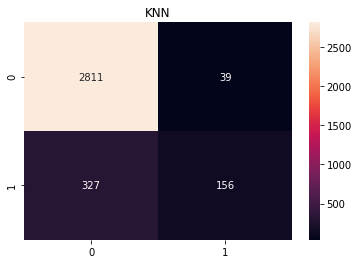

In [96]:
#%% [markdown]
k_neighbors_conf_matrix   = metrics.confusion_matrix(y, stratified_cv(X, y, neighbors.KNeighborsClassifier))
sns.heatmap(k_neighbors_conf_matrix, annot=True,  fmt='');
title = 'KNN'
plt.title(title);



/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

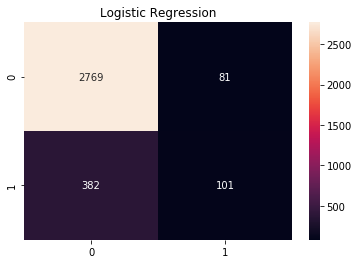

In [97]:
#%% [markdown]
logistic_reg_conf_matrix  = metrics.confusion_matrix(y, stratified_cv(X, y, linear_model.LogisticRegression))
sns.heatmap(logistic_reg_conf_matrix, annot=True,  fmt='');
title = 'Logistic Regression'
plt.title(title);

In [98]:
#Save logs to the service
run.log(name="message", value="gbc.feature_importances_")
run.log_image("Feature importance",plot = plt)


<Figure size 432x288 with 0 Axes>

In [99]:
#Save model to disk
from sklearn.externals import joblib
joblib.dump(value=gbc, filename="churn-model.pkl")


['churn-model.pkl']

In [100]:
#Registre model in Azure ML Service
from azureml.core.model import Model
model = Model.register(workspace=ws, model_path="churn-model.pkl", model_name="telco-churn-azure-notebook")


Registering model telco-churn-azure-notebook


In [101]:
run.complete()
